## Set up

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score
import seaborn as sns

from fit import fit_categorical_survival, categorical_signal
from models import MergeRareCategories
from pipelines import benchmark_pipelines, build_classifier_pipelines, build_regression_pipelines, categorical_input_columns, evaluate_training_size_dependence, pipelines, reconstruct_categorical_variable_names_Richard
from source import read_preprocessed_data
from transform import load_process_and_store_spreadsheets, survival_histograms
from views import categorical_signal_summary, plot_confusion_matrix, view_as_exponential, view_decision_tree_julian, view_linear_model_richard, view_linear_model_julian

In [2]:
def harmonic_mean(t0, t1):
    return t0 * t1 / (t0 + t1)

In [3]:
load_process_and_store_spreadsheets(
#     spread_sheet_filename='2019-08-27_PLASMA_SOMATIC_Results_Groningen.xlsx', 
    transformation=harmonic_mean,
)

X_train, y_train = read_preprocessed_data("output/train.tsv")
X_test, y_test = read_preprocessed_data("output/test.tsv")

## Overall survival and progression free survival
### Population results
To first get an idea of the overall factors, we have a brief look at the data as a whole.

In [4]:
# Combined set for analysis only (not to be used for models).
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

First calculate distribution of the overall survival (OS) and progression free survival (PFS) and the cumulative distribution.

In [5]:
# Calculate the distribution and cumulative distribution for:
# 1) overall survival.
(t_OS, p_OS), (t_OS_cum, p_OS_cum) = survival_histograms(y['OS_days'], hist_bins=10, cum_hist_bins=15)
# 2) progression free survival.
(t_PFS, p_PFS), (t_PFS_cum, p_PFS_cum) = survival_histograms(y['PFS_days'], hist_bins=10, cum_hist_bins=15)

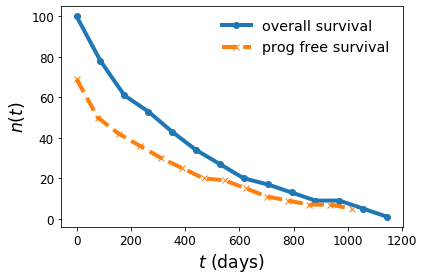

In [6]:
plt.figure()
plt.plot(t_OS_cum, p_OS_cum, '-o', label='overall survival')
plt.plot(t_PFS_cum, p_PFS_cum, '--x', label='prog free survival')
plt.xlabel('$t$ (days)')
plt.ylabel('$n(t)$')
plt.legend(frameon=False)

which clearly shows an exponentially decaying function (as a side note, if the original distribution is exponential, than so is the cumulative function). 

If patients indeed decay exponentially
$$N(t) = N_0 \exp\left(-\frac{t}{\tau}\ln 2\right) ,$$
then the half life $\tau$ can be determined from the slope
$$
\ln[N(t)] = -\frac{\ln 2}{\tau} t + \ln N_0.
$$
Let us fit this to the distribution:


(-22.88, 1166.88)

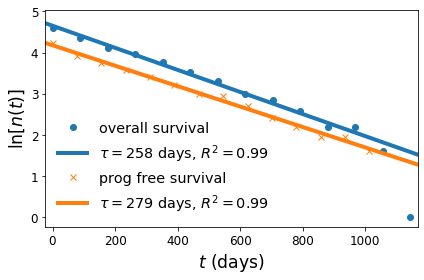

In [7]:
# The last datum is an outlier.
outliers = [len(p_OS_cum) - 1]
view_as_exponential(t_OS_cum, p_OS_cum, outlier_indices=outliers, markers=['o', '-'], label='overall survival')
view_as_exponential(t_PFS_cum, p_PFS_cum, markers=['x', '-'], label='prog free survival')
plt.gca()
dt = t_OS_cum[-1] - t_OS_cum[0]
plt.xlim([t_OS_cum[0] - 0.02*dt, t_OS_cum[-1] + 0.02*dt])

### Phenotype differences
Two exponentials form approximately an exponential
$$
\frac{n_1}{N} e^{-\alpha_1 t} + \frac{n_2}{N} e^{-\alpha_2 t} \approx \exp\left(-\frac{n_1}{N}\alpha_1 t - \frac{n_2}{N}\alpha_2t \right) \equiv \exp(-\alpha t) ,
$$
with $N=n_1 + n_2$, when $n_2(\alpha_1 - \alpha_2)/N t \ll 1$ for relevant $t$. That is, our new $\alpha$ is a weighted average of the individual ones.

In [8]:
# First merge all categories that occur less than 30 times.
X = MergeRareCategories(thresshold=30, categorical_columns=categorical_input_columns).fit_transform(X)

In [9]:
X

,TP53,KRAS,FGFR1,PTEN,FBXW7,KDR,MTOR,EGFR,MET,CDKN2A,...,therapyline,smokingstatus,Systemischetherapie,histology_grouped,lymfmeta,brainmeta,adrenalmeta,livermeta,lungmeta,skeletonmeta
Patient ID,,,,,,,,,,,,,,,,,,,,,
7181,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,2,previous,nivolumab,adeno,metastasis present,no metastasis present,no metastasis present,no metastasis present,metastasis present,metastasis present
7149,0.039636,0.000375,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,2,unknown+non smoker,nivolumab,adeno,no metastasis present,no metastasis present,no metastasis present,no metastasis present,metastasis present,no metastasis present
1023,0.019633,0.000000,0.0,0.000635,0.0,0.0,0.0,0.000000,0.0,0.012264,...,2,smoker,nivolumab,squamous,metastasis present,no metastasis present,no metastasis present,metastasis present,metastasis present,metastasis present
1089,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,2,smoker,nivolumab,adeno,metastasis present,no metastasis present,no metastasis present,no metastasis present,metastasis present,no metastasis present
7090,0.002559,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,2,previous,nivolumab,other,metastasis present,no metastasis present,metastasis present,no metastasis present,metastasis present,metastasis present
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,2,smoker,nivolumab,squamous,metastasis present,metastasis present,metastasis present,no metastasis present,no metastasis present,no metastasis present
1133,0.021078,0.021257,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,2,smoker,nivolumab,adeno,metastasis present,metastasis present,metastasis present,no metastasis present,no metastasis present,no metastasis present
1024,0.072976,0.000000,0.0,0.000000,0.0,0.0,0.0,0.092375,0.0,0.000000,...,3+1+0+4,unknown+non smoker,nivolumab,adeno,metastasis present,no metastasis present,no metastasis present,no metastasis present,metastasis present,metastasis present


In [10]:
from fit import fit_categorical_survival

X['gender']
df = fit_categorical_survival(X['gender'], y['OS_days'])
df

,tau,sigma_t,n,r
all,216.686,306.002,125,-0.949971
male,224.428,305.519,71,-0.975729
female,273.239,306.082,54,-0.994726


In [11]:
effect_summary = categorical_signal_summary(X, y['OS_days'], categorical_input_columns)

In [12]:
effect_summary.round(2)

delta tau  \
category            item                                                            
gender              male-female                                             48.81   
stage               4-3                                                     62.48   
therapyline         2-3+1+0+4                                               35.37   
smokingstatus       previous-unknown+non smoker                             32.10   
                    previous-smoker                                        122.01   
                    unknown+non smoker-smoker                              154.11   
Systemischetherapie nivolumab-ipi-novu+pembrolizumab+durvalumab+ate...      33.39   
histology_grouped   adeno-squamous                                          36.68   
                    adeno-other                                             68.55   
                    squamous-other                                         105.24   
lymfmeta            metastasis present-no metastasis present               128.33   
brainmeta           no metastasis present-metastasis present                24.07   
adrenalmeta         no metastasis present-metastasis present                41.82   
livermeta           no metastasis present-metastasis present                51.41   
lungmeta            metastasis present-no metastasis present                26.22   
skeletonmeta        metastasis present-no metastasis present                 2.63   

                                                                        signal to noise  
category            item                                                                 
gender              male-female                                                    0.16  
stage               4-3                                                            0.20  
therapyline         2-3+1+0+4                                                      0.12  
smokingstatus       previous-unknown+non smoker                                    0.10  
                    previous-smoker                                                0.40  
                    unknown+non smoker-smoker                                      0.50  
Systemischetherapie nivolumab-ipi-novu+pembrolizumab+durvalumab+ate...             0.11  
histology_grouped   adeno-squamous                                                 0.12  
                    adeno-other                                                    0.22  
                    squamous-other                                                 0.34  
lymfmeta            metastasis present-no metastasis present                       0.42  
brainmeta           no metastasis present-metastasis present                       0.08  
adrenalmeta         no metastasis present-metastasis present                       0.14  
livermeta           no metastasis present-metastasis present                       0.17  
lungmeta            metastasis present-no metastasis present                       0.09  
skeletonmeta        metastasis present-no metastasis present                       0.01

In [13]:
effect_summary.round(2)

delta tau  \
category            item                                                            
gender              male-female                                             48.81   
stage               4-3                                                     62.48   
therapyline         2-3+1+0+4                                               35.37   
smokingstatus       previous-unknown+non smoker                             32.10   
                    previous-smoker                                        122.01   
                    unknown+non smoker-smoker                              154.11   
Systemischetherapie nivolumab-ipi-novu+pembrolizumab+durvalumab+ate...      33.39   
histology_grouped   adeno-squamous                                          36.68   
                    adeno-other                                             68.55   
                    squamous-other                                         105.24   
lymfmeta            metastasis present-no metastasis present               128.33   
brainmeta           no metastasis present-metastasis present                24.07   
adrenalmeta         no metastasis present-metastasis present                41.82   
livermeta           no metastasis present-metastasis present                51.41   
lungmeta            metastasis present-no metastasis present                26.22   
skeletonmeta        metastasis present-no metastasis present                 2.63   

                                                                        signal to noise  
category            item                                                                 
gender              male-female                                                    0.16  
stage               4-3                                                            0.20  
therapyline         2-3+1+0+4                                                      0.12  
smokingstatus       previous-unknown+non smoker                                    0.10  
                    previous-smoker                                                0.40  
                    unknown+non smoker-smoker                                      0.50  
Systemischetherapie nivolumab-ipi-novu+pembrolizumab+durvalumab+ate...             0.11  
histology_grouped   adeno-squamous                                                 0.12  
                    adeno-other                                                    0.22  
                    squamous-other                                                 0.34  
lymfmeta            metastasis present-no metastasis present                       0.42  
brainmeta           no metastasis present-metastasis present                       0.08  
adrenalmeta         no metastasis present-metastasis present                       0.14  
livermeta           no metastasis present-metastasis present                       0.17  
lungmeta            metastasis present-no metastasis present                       0.09  
skeletonmeta        metastasis present-no metastasis present                       0.01

In [14]:
effect_summary = categorical_signal_summary(X, y['PFS_days'], categorical_input_columns)
effect_summary

delta tau  \
category            item                                                              
gender              male-female                                           83.196206   
stage               4-3                                                   91.530266   
therapyline         2-3+1+0+4                                             59.584430   
smokingstatus       previous-unknown+non smoker                           81.139077   
                    previous-smoker                                      128.607674   
                    unknown+non smoker-smoker                             47.468598   
Systemischetherapie nivolumab-ipi-novu+pembrolizumab+durvalumab+ate...   117.411684   
histology_grouped   adeno-squamous                                       124.046350   
                    adeno-other                                          916.065350   
                    squamous-other                                      1040.111701   
lymfmeta            metastasis present-no metastasis present              71.579430   
brainmeta           no metastasis present-metastasis present             116.215816   
adrenalmeta         no metastasis present-metastasis present              23.122314   
livermeta           no metastasis present-metastasis present              76.470002   
lungmeta            metastasis present-no metastasis present             141.705555   
skeletonmeta        metastasis present-no metastasis present             143.056747   

                                                                        signal to noise  
category            item                                                                 
gender              male-female                                                0.288299  
stage               4-3                                                        0.317178  
therapyline         2-3+1+0+4                                                  0.206477  
smokingstatus       previous-unknown+non smoker                                0.281170  
                    previous-smoker                                            0.445662  
                    unknown+non smoker-smoker                                  0.164492  
Systemischetherapie nivolumab-ipi-novu+pembrolizumab+durvalumab+ate...         0.406865  
histology_grouped   adeno-squamous                                             0.429856  
                    adeno-other                                                3.174428  
                    squamous-other                                             3.604284  
lymfmeta            metastasis present-no metastasis present                   0.248043  
brainmeta           no metastasis present-metastasis present                   0.402721  
adrenalmeta         no metastasis present-metastasis present                   0.080125  
livermeta           no metastasis present-metastasis present                   0.264990  
lungmeta            metastasis present-no metastasis present                   0.491050  
skeletonmeta        metastasis present-no metastasis present                   0.495732

### Theoretical lower bound on model performance
Assuming the worst case scenario, we can now derive a lower bound on the mean squared error, given that the data is distributed according to the exponentially decaying function.

Normalising $N(t) = N_0 e^{-t \ln 2 / \tau}$ to $p(t)$ gives 
$$
p(t) = \alpha e^{-\alpha t} ,
$$
with $\alpha = \ln 2/\tau$. The standard deviation is nothing but the root mean squared error of the average:
$$
\sigma_t^2 = \langle t^2 \rangle - \langle t \rangle^2 .
$$
Calculating the avarage $\langle t \rangle = 1/\alpha$ and the two point function $\langle t^2 \rangle= 2/\alpha^2$ allows one to express the standard deviation as.
$$
\sigma_t^2 = \alpha^{-2} = \left( \frac{\tau}{\ln 2} \right)^2 .
$$
A model should at least be able to out perform the following mean squared error:
$$
\Delta e^2 = \frac{1}{N}\left(n_1 \frac{{\tau_1}^2}{\ln^2 2} + n_2 \frac{{\tau_2}^2}{\ln^2 2} \right) \, .
$$

Using the value above $\tau =258$ days gives a variance of

### Tuning the pipeline
We use a variety of different pipelines and different algorithms to try to squeeze as much signal from the data as possible. Let us focus on the overall survival first.

In [15]:
# Construct a variety of pipelines.
pipelines = build_regression_pipelines()

# And benchmark them using the root mean squared error.
rmse = lambda x, y: mean_squared_error(x, y) ** 0.5

Briefly, the types of models in this list:
- Decision tree: Consecutively split the data in two branches based on one of the variables.
- Random forest: collection of decision trees in parallel, each tree gets a subset of the training data.
- Gradient boosting: collection of decision trees in series, each refining the result of the previous tree.
- K-neighbours: Use average of $k$ neighbouring points.
- Elastic net: Linear regression with penalties on the slopes.
- SVR: Support vector machine that implicitly takes into account polynomials of the input variables.
- DummyRegressor: Baseline model that predicts according a specific rule (in this case, take the median value).

Pipelines:
- Richard: Use only phenotype data, and some categorical preprocessing.
- Julian: Convert mutation data to columns using transformation described above (harmonic mean).
- Freeman: Use all data together.
- Lev: Democratic vote of Richard & Julian.

#### overall survival

In [16]:
from sklearn.metrics import make_scorer
rmse_scorer = make_scorer(rmse)

In [17]:
benchmark_result = benchmark_pipelines(
    pipelines, X, y['OS_days'], metric=rmse_scorer
)
benchmark_result

,Richard mean,Richard std,Julian mean,Julian std,Freeman mean,Freeman std,Lev mean,Lev std
DecisionTreeRegressor,365.990915,42.469776,341.738921,40.110715,357.459819,48.475255,330.145636,41.629976
RandomForestRegressor,314.037922,37.752657,325.793607,55.079099,317.956780,52.312016,305.447621,44.227318
GradientBoostingRegressor,316.254406,42.390632,323.566260,40.922256,317.141973,43.468602,310.998753,44.067815
KNeighborsRegressor,337.504997,39.404306,332.017825,53.543106,325.786288,42.184000,320.419488,47.845897
ElasticNet,296.573517,44.430744,303.720758,50.143083,296.816167,39.029482,298.809229,47.550852
LinearRegression,315.425004,29.446131,335.745592,75.870196,3786.454850,6718.548942,308.714740,52.383809
ARDRegression,319.326772,38.644897,315.771926,60.656512,311.713293,32.170566,312.228078,48.848020
BayesianRidge,298.223510,46.779257,313.767435,58.025570,304.239855,43.325862,303.848951,51.982458
SVR,321.001779,65.163347,320.207460,65.397110,321.504126,65.209228,320.597004,65.279643
DummyRegressor,321.572213,65.253353,321.572213,65.253353,321.572213,65.253353,321.572213,65.253353


### Training size dependence

In [18]:
p_Lev = pipelines['LinearRegression']['Lev']
m, err, std = evaluate_training_size_dependence(p_Lev, X, y["OS_days"],metric=rmse)

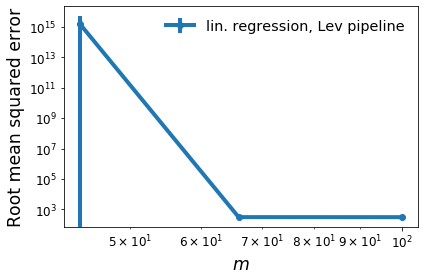

In [19]:

plt.ylabel('Root mean squared error')
plt.xlabel('$m$')
plt.errorbar(m[2:], err[2:], yerr=std[2:], fmt='o-', label='lin. regression, Lev pipeline')
plt.xscale("log", nonposx='clip')
plt.yscale("log")
plt.legend(frameon=False)

The data indicates that the linear regression model with the `Lev` pipeline (which combines the `Richard` and `Julian` pipelines) gives the best results.

#### progression free survival

In [20]:
benchmark_result = benchmark_pipelines(
    pipelines, X, y["OS_days"], metric=rmse_scorer
)
benchmark_result

,Richard mean,Richard std,Julian mean,Julian std,Freeman mean,Freeman std,Lev mean,Lev std
DecisionTreeRegressor,365.990915,42.469776,341.738921,40.110715,357.459819,48.475255,330.145636,41.629976
RandomForestRegressor,314.037922,37.752657,325.793607,55.079099,317.956780,52.312016,305.447621,44.227318
GradientBoostingRegressor,316.254406,42.390632,323.566260,40.922256,317.141973,43.468602,310.998753,44.067815
KNeighborsRegressor,337.504997,39.404306,332.017825,53.543106,325.786288,42.184000,320.419488,47.845897
ElasticNet,296.573517,44.430744,303.720758,50.143083,296.816167,39.029482,298.809229,47.550852
LinearRegression,315.425004,29.446131,335.745592,75.870196,3786.454850,6718.548942,308.714740,52.383809
ARDRegression,319.326772,38.644897,315.771926,60.656512,311.713293,32.170566,312.228078,48.848020
BayesianRidge,298.223510,46.779257,313.767435,58.025570,304.239855,43.325862,303.848951,51.982458
SVR,321.001779,65.163347,320.207460,65.397110,321.504126,65.209228,320.597004,65.279643
DummyRegressor,321.572213,65.253353,321.572213,65.253353,321.572213,65.253353,321.572213,65.253353


- $\Delta \tau$ 
- Calculation of $\Delta \tau$ for various phenotypes.
- Tuning of pipeline.
- Somatic vs all
- Hybrid model best performance.
### Decypher effects of input features

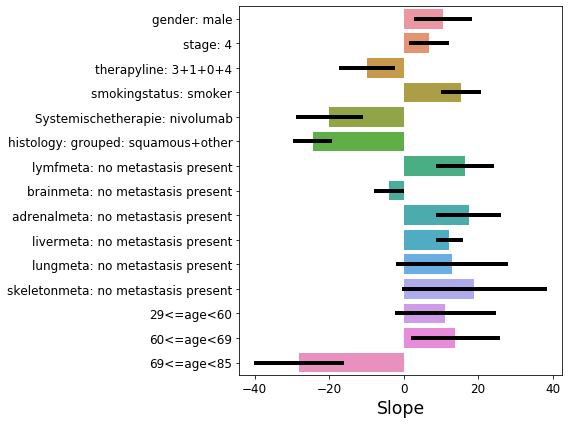

In [21]:
p_richard = pipelines['ElasticNet']['Richard']
view_linear_model_richard(X, y["OS_days"], p_richard)

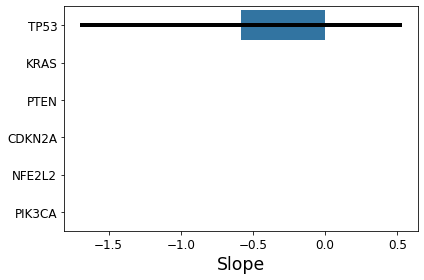

In [22]:
p_julian = pipelines['ElasticNet']['Julian']

view_linear_model_julian(X, y['OS_days'], p_julian)
# view_linear_model_julian

The sheer size of the coefficients are related to the size of the input variables (which are calculated using the harmonic mean). But the positive sign of `TP53` indicates that the presence of this variable is indicative for prolonger survival.

## Classification
**Goal**: Identify patients that don't respond.

These patients we don't have to treat.

In [23]:
y_train_resp = y_train["response_grouped"]
y_test_resp = y_test["response_grouped"]

response_labels = ['non responder (sd+pd)', 'responder (pr+cr)']
pos_label = 'non responder (sd+pd)'

We want to:
- Maximize our predictive capacity, we do this by maximizing the area under receiver operating curve.
- And at the same time, we don't want to deny patients treatment that could potentially benefit.

The latter statement translates to a minimisation of false positives (predicted is non-responder \[=positive\], but is actually a responder \[=false\]).

We use the area under the receiver operating curve $r_{\mathrm{TP}}(r_{\mathrm{FP}})$:
$$
    A = \int_0^1 r_{\mathrm{TP}}(r_{\mathrm{FP}}) \, \mathrm{d}r_{\mathrm{FP}} \, .
$$
to quantify the models predictive capacity.

In [24]:
# We evaluate the predictive capacity using AUC of ROC.
from sklearn.preprocessing import LabelBinarizer
def auc(y_true, y_pred):
    l = LabelBinarizer().fit(y_true)
    return roc_auc_score(l.transform(y_true), l.transform(y_pred), average='weighted')

In [ ]:
ps_class = build_classifier_pipelines()

In [25]:
b = benchmark_pipelines(
    ps_class, X, y['response_grouped'], metric='roc_auc',
)
# print(b.round(2).to_latex())

In [27]:
b

,Richard mean,Richard std,Julian mean,Julian std,Freeman mean,Freeman std
DecisionTreeClassifier,0.529205,0.134960,0.573733,0.032676,0.481725,0.112864
RandomForestClassifier,0.563590,0.131185,0.634566,0.072952,0.607031,0.139015
GaussianNB,0.577931,0.070914,0.593108,0.141784,0.614049,0.056710
GradientBoostingClassifier,0.565253,0.179918,0.601462,0.041414,0.524861,0.130868
KNeighborsClassifier,0.527054,0.092087,0.479602,0.033442,0.502799,0.084274
LogisticRegression,0.593400,0.115495,0.500000,0.000000,0.590894,0.113954
SVC,0.588694,0.085585,0.562907,0.057813,0.517084,0.062248
DummyClassifier,0.500000,0.000000,0.500000,0.000000,0.500000,0.000000


It seems that our `Julian` pipeline using a DecisionTreeClassifier is the overall winner. Let us take a more in depth look at the confusion matrix.

In [28]:
p_win = ps_class['RandomForestClassifier']['Julian']
# view_decision_tree_julian(p_win, save_to='classifier_tree.png')

In [29]:
p_win.fit(X_train, y_train_resp)

Pipeline(memory=None,
         steps=[('select_columns',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function select_no_phenotype_columns at 0x7fccc1e76f28>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, pass_y='deprecated',
                                     validate=False)),
                ('filter_rare_mutations',
                 SparseFeatureFilter(columns_to_consider='all', thresshold=None,
                                     top_k_features...
                 RandomForestClassifier(bootstrap=True,
                                        class_weight='balanced_subsample',
                                        criterion='gini', max_depth=5,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=

Confusion matrix, without normalization
[[17 14]
 [ 2  5]]


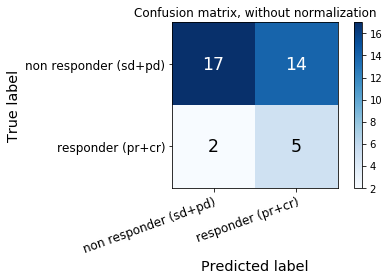

In [30]:
plot_confusion_matrix(y_test_resp, p_win.predict(X_test), classes=response_labels)

In [31]:
pos_label_index = np.argwhere(p_win.classes_ == pos_label)[0][0]
p = p_win.predict_proba(X_test)[:, pos_label_index]

fpr, tpr, thresholds = roc_curve(y_test_resp.values, p, pos_label=pos_label)

Text(0, 0.5, '$r_{\\mathrm{TP}}$')

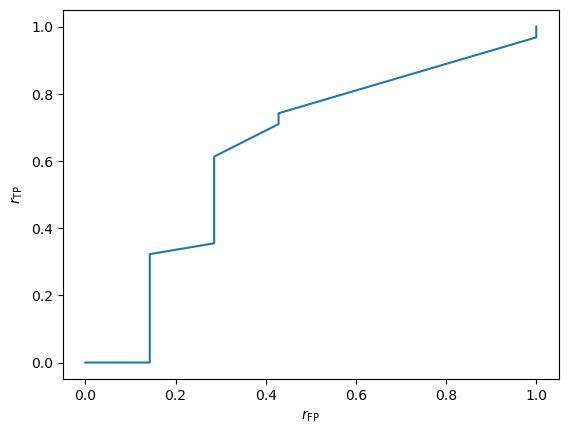

In [32]:
plt.plot(fpr, tpr)
plt.xlabel(r'$r_{\mathrm{FP}}$')
plt.ylabel(r'$r_{\mathrm{TP}}$')

In [33]:
print(type(y_test_resp.values))
print(type(p_win.predict(X_test)))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Training size dependence.

In [34]:
p_Julian = ps_class['DecisionTreeClassifier']['Julian']
m, auc_mean, auc_std = evaluate_training_size_dependence(p_Julian, X, y['response_grouped'], metric=auc)

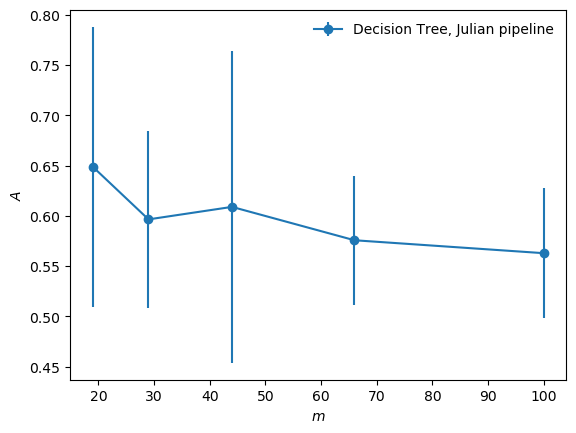

In [35]:
plt.errorbar(m ,auc_mean, yerr=auc_std,fmt='o-', label='Decision Tree, Julian pipeline')
plt.ylabel('$A$')
plt.xlabel('$m$')
plt.legend(frameon=False)